In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

from multihopkg.data_utils import load_dictionaries, load_triples_hrt

# --- CONFIG ---
EMBEDDING_DIR = "./models/graph_embeddings/transE_mquake_dim500/"
TRIPLET_FILE = "./data/mquake/expNpruned_triplets.txt"
DICTIONARY_PATH = "./data/mquake/"
NUM_SAMPLES = 1000
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- Load Dictionaries -- 


# --- LOAD EMBEDDINGS ---
entity_embeddings = torch.from_numpy(np.load(EMBEDDING_DIR + "entity_embedding.npy"))
relation_embeddings = torch.from_numpy(np.load(EMBEDDING_DIR + "relation_embedding.npy"))

id2entity, entity2id, id2relation, relation2id = load_dictionaries(DICTIONARY_PATH)
triplets = load_triples_hrt(TRIPLET_FILE, entity2id, relation2id,True)
print(f"Loaded {len(triplets)} triplets.")


/home/ottersome/.cache/pypoetry/virtualenvs/multihopkg-RYt8Rg79-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 710893 triplets.


In [3]:
# --- SAMPLE TRUE TRIPLETS ---
true_triplets = random.sample(triplets, min(NUM_SAMPLES, len(triplets)))

# --- SAMPLE FALSE TRIPLETS ---
all_entities = list(range(entity_embeddings.shape[0]))
all_relations = list(range(relation_embeddings.shape[0]))
triplet_set = set(triplets)
false_triplets = set()
while len(false_triplets) < len(true_triplets):
    h = random.choice(all_entities)
    r = random.choice(all_relations)
    t = random.choice(all_entities)
    if (h, r, t) not in triplet_set:
        false_triplets.add((h, r, t))
false_triplets = list(false_triplets)

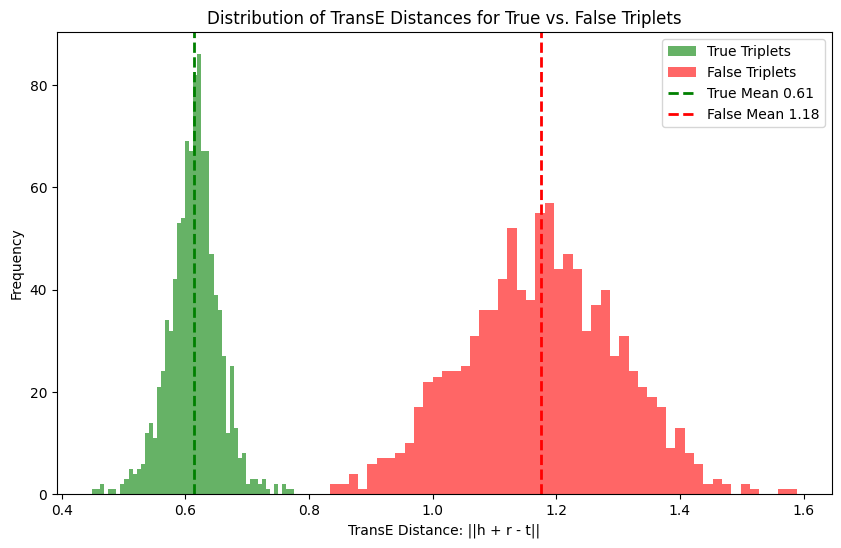

In [6]:
# --- COMPUTE TRANSE DISTANCES ---
def transe_distance(h, r, t):
    h_emb = entity_embeddings[h]
    r_emb = relation_embeddings[r]
    t_emb = entity_embeddings[t]
    return torch.linalg.norm(h_emb + r_emb - t_emb).item()

true_distances = [transe_distance(h, r, t) for (h, r, t) in true_triplets]
false_distances = [transe_distance(h, r, t) for (h, r, t) in false_triplets]

true_distances_mean = np.mean(true_distances)
false_distances_mean = np.mean(false_distances)

# --- PLOT ---
plt.figure(figsize=(10, 6))
plt.hist(true_distances, bins=50, alpha=0.6, label="True Triplets", color="green")
plt.hist(false_distances, bins=50, alpha=0.6, label="False Triplets", color="red")
plt.xlabel("TransE Distance: ||h + r - t||")
plt.ylabel("Frequency")
plt.axvline(true_distances_mean.item(), color="green", linestyle="dashed", linewidth=2, label=f"True Mean {true_distances_mean.item():.2f}")
plt.axvline(false_distances_mean.item(), color="red", linestyle="dashed", linewidth=2, label=f"False Mean {false_distances_mean.item():.2f}")

plt.title("Distribution of TransE Distances for True vs. False Triplets")
plt.legend()
plt.show()